In [1]:
# !pip install pydrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# download = drive.CreateFile({'id': '1U3-XsgxUF_v_K4jXhwl6LJVty5eR9EUm'})
# download.GetContentFile('data.zip')
# ! unzip data.zip

In [2]:
# https://drive.google.com/open?id=1N6efgxjRdQExrz7z84_iJiUGXIWad6FU
# download = drive.CreateFile({'id': '1N6efgxjRdQExrz7z84_iJiUGXIWad6FU'})
# download.GetContentFile('image_vectors.pickle')

In [1]:
import keras as ks
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential,Model
from keras.layers import Conv2D,UpSampling2D,Dense,InputLayer,RepeatVector,Reshape,concatenate,Input

Using TensorFlow backend.


In [2]:
def get_train_ids():
    cap_path="captions"

    train_ids=open(cap_path+'/Flickr_8k.trainImages.txt','r')
    train_ids=train_ids.read()
    train_ids=train_ids.strip().split('\n')
    print(len(train_ids))
    return train_ids
    

def get_images_data(train_ids):
    images_path="images"
    images={}
    k=1
    for i in train_ids:

        image=cv2.imread(images_path+"/"+i,1)
        image=cv2.resize(image,(256,256))
        lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l_channel,a_channel,b_channel = cv2.split(lab_image)
        images[i]={}
        images[i]["l"]=l_channel
        images[i]["a"]=a_channel #normalize
        images[i]["b"]=b_channel
        print(k,end=" ")
        k+=1
        
    print()
    print(len(images))
    return images

def inception_resnet_features():
    file=open("resnet_classif_colorpic.pickle","rb")
    images_res_f=pickle.load(file)
    file.close()
    print(len(images_res_f))
    return images_res_f

In [3]:
train_ids=get_train_ids()
images_data=get_images_data(train_ids[:20])
images_res_f=inception_resnet_features()

6000
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
20
6000


In [4]:
def data_making(train_ids,images_data,images_res_f):
    data=[]#L-channel
    data_inception=[]#inception features
    data_keys=[]#keys
    prediction=[]#a,b - channels
    k=0
    for i in train_ids:
        data_keys.append([i])
        data.append(images_data[i]["l"].reshape((256,256,1)))
        prediction.append(np.stack([images_data[i]["a"],images_data[i]["b"]],axis=-1))
        arr=np.zeros((1000))
        arr[images_res_f[i]]=1
        data_inception.append(arr)
        print(k,end=" ")
        k+=1
        
    print()
    print(len(data),len(data_inception),len(data_keys),len(prediction))
    return data,data_inception,data_keys,prediction

In [5]:
data,data_inception,data_keys,prediction=data_making(train_ids[0:20],images_data,images_res_f)
data=np.array(data)
print(1)
data_inception=np.array(data_inception)
data_keys=np.array(data_keys)
prediction=np.array(prediction)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
20 20 20 20
1


In [6]:
data.shape,data_inception.shape,data_keys.shape,prediction.shape

((20, 256, 256, 1), (20, 1000), (20, 1), (20, 256, 256, 2))

0 2513260012_03d33305cf.jpg (256, 2)


(<matplotlib.image.AxesImage at 0x18ee01b6e48>, None)

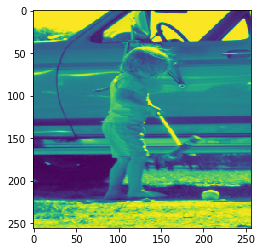

In [7]:
plt.imshow(data[1,:,:,0]),print(np.argmax(data_inception[0][0]),data_keys[0][0],prediction[0][0].shape)

In [8]:
# encoder: kernel=(3,3), activation=relu, padding="same"
# (256,256,1)->(256,256,64)->(128,128,128)->(128,128,128)->(64,64,256)->(64,64,256)->(32,32,512)->(32,32,512)->(32,32,256)

#fusion(encoder_output+resnet_output)
# resnet_output->(1000)->(32,32,1000), fusion-> stack(resnet_out,encoder_out,axis=-1)  -> (32,32,1256)
# (32,32,1256)->(32,32,256)(kernel=(1,1))

#decoder
# (32,32,256)->(32,32,128)->(64,64,64)->(128,128,32)->(128,128,16)->(128,128,2)->(256,256,2)(tanh)

def create_model():
    #encoder
    inp1=Input(shape=(256,256,1),name="inp1")
    enc1=Conv2D(64,kernel_size=(3,3),strides=(2,2),padding="SAME",activation="relu",name="enc1")(inp1)
    enc2=Conv2D(128,kernel_size=(3,3),padding="SAME",activation="relu",name="enc2")(enc1)
    enc3=Conv2D(128,kernel_size=(3,3),strides=(2,2),padding="SAME",activation="relu",name="enc3")(enc2)
    enc4=Conv2D(256,kernel_size=(3,3),padding="SAME",activation="relu",name="enc4")(enc3)
    enc5=Conv2D(256,kernel_size=(3,3),strides=(2,2),padding="SAME",activation="relu",name="enc5")(enc4)
    enc6=Conv2D(512,kernel_size=(3,3),padding="SAME",activation="relu",name="enc6")(enc5)
    enc7=Conv2D(512,kernel_size=(3,3),padding="SAME",activation="relu",name="enc7")(enc6)
    enc_out=Conv2D(256,kernel_size=(3,3),padding="SAME",activation="relu",name="enc_out")(enc7)  #(32,32,256)
    
    #fusion
    inp2=Input(shape=(1000,),name="inp2")
    f1=RepeatVector(32*32,name="f1")(inp2)
    f2=Reshape(target_shape=(32,32,1000),name="f2")(f1)
    f3=concatenate([enc_out,f2],axis=-1,name="f3")
    f_out=Conv2D(256,kernel_size=(1,1),padding="SAME",activation="relu",name="f_out")(f3)
    
    #decoder
    dec1=Conv2D(128,kernel_size=(3,3),padding="SAME",activation="relu",name="dec1")(f_out)
    dec2=UpSampling2D(name="dec2")(dec1)
    dec3=Conv2D(64,kernel_size=(3,3),padding="SAME",activation="relu",name="dec3")(dec2)
    dec4=UpSampling2D(name="dec4")(dec3)
    dec5=Conv2D(32,kernel_size=(3,3),padding="SAME",activation="relu",name="dec5")(dec4)
    dec6=Conv2D(16,kernel_size=(3,3),padding="SAME",activation="relu",name="dec6")(dec5)
    dec7=Conv2D(2,kernel_size=(3,3),padding="SAME",activation="relu",name="dec7")(dec6)
    dec_out=UpSampling2D(name="dec_out")(dec7)
    opti=ks.optimizers.adam()
    model=Model(inputs=[inp1,inp2],outputs=dec_out)
    model.compile(loss=ks.losses.mse,metrics=["accuracy","mae"],optimizer=opti)
    
    return model    

In [50]:
# model=create_model()


In [24]:
model.fit(x=[data,data_inception],y=prediction,epochs=30,batch_size=5)

Epoch 1/30
20/20 [==============================] - 38s 2s/step - loss: 259.1555 - acc: 0.6038 - mean_absolute_error: 11.6040
Epoch 2/30
20/20 [==============================] - 36s 2s/step - loss: 274.9004 - acc: 0.6039 - mean_absolute_error: 12.1002
Epoch 3/30
20/20 [==============================] - 34s 2s/step - loss: 254.7867 - acc: 0.6041 - mean_absolute_error: 11.5321
Epoch 4/30
20/20 [==============================] - 39s 2s/step - loss: 253.7132 - acc: 0.6052 - mean_absolute_error: 11.4806
Epoch 5/30
20/20 [==============================] - 36s 2s/step - loss: 262.0767 - acc: 0.6054 - mean_absolute_error: 11.6023
Epoch 6/30
20/20 [==============================] - 38s 2s/step - loss: 265.9897 - acc: 0.6055 - mean_absolute_error: 11.7367
Epoch 7/30
20/20 [==============================] - 37s 2s/step - loss: 250.9235 - acc: 0.6053 - mean_absolute_error: 11.6287
Epoch 8/30
20/20 [==============================] - 37s 2s/step - loss: 259.6404 - acc: 0.6053 - mean_absolute_error: 

In [19]:
# model=ks.models.load_model("color_pic_model.h5")

In [25]:
def output_pic(k=0):
    output = model.predict([data[k:k+1],data_inception[k:k+1]])
    output = output

    canvas = np.zeros((256,256, 3))
    canvas[:,:,0] = data[k][:,:,0]
    canvas[:,:,1:] = np.round(output[0])
    canvas=canvas.astype(np.uint8)    #displayed as it is
    print(canvas.dtype,canvas.shape)
    canvas=cv2.cvtColor(canvas, cv2.COLOR_LAB2BGR)

    fig=plt.figure(figsize=(16,16))
    ax1=fig.add_subplot(1,3,1)
    ax2=fig.add_subplot(1,3,2)
    ax3=fig.add_subplot(1,3,3)
    original=cv2.imread("images"+"/"+train_ids[k],1)
    original=cv2.resize(original,(256,256))
    ax1.imshow(data[k][:,:,0],)

    ax2.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    # ax3.imshow(original)
    ax3.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    # imsave("img_result.png", lab2rgb(canvas))
    # imsave("img_gray_scale.png", rgb2gray(lab2rgb(canvas)))
    return  

In [32]:
model.save("color_pic_model1.h5")

uint8 (256, 256, 3)


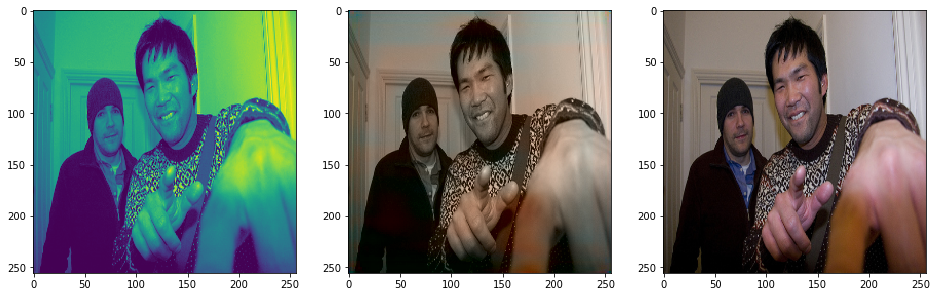

In [38]:
output_pic(17)

In [109]:
np.round(output),prediction[k]

(array([[[[19.,  0.],
          [30., 31.],
          [31., 33.],
          ...,
          [16., 21.],
          [16., 23.],
          [ 5., 22.]],
 
         [[46., 20.],
          [60., 47.],
          [65., 50.],
          ...,
          [43., 41.],
          [36., 42.],
          [16., 33.]],
 
         [[44., 15.],
          [63., 47.],
          [63., 49.],
          ...,
          [44., 43.],
          [41., 46.],
          [16., 36.]],
 
         ...,
 
         [[46., 30.],
          [70., 39.],
          [72., 50.],
          ...,
          [46., 49.],
          [45., 54.],
          [22., 41.]],
 
         [[45., 28.],
          [69., 36.],
          [69., 50.],
          ...,
          [50., 55.],
          [48., 54.],
          [22., 43.]],
 
         [[30., 18.],
          [43., 21.],
          [43., 30.],
          ...,
          [25., 29.],
          [25., 31.],
          [ 2., 14.]]]], dtype=float32), array([[[128, 128],
         [128, 128],
         [128, 128],
      

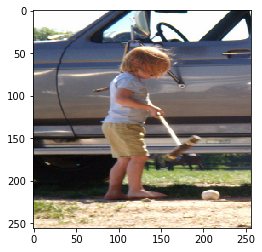

In [100]:
images_data[train_ids[1]]
canvas = np.zeros((256,256, 3))
canvas[:,:,0] = images_data[train_ids[1]]["l"]
canvas[:,:,1] = images_data[train_ids[1]]["a"]
canvas[:,:,2] = images_data[train_ids[1]]["b"]
canvas=canvas.astype(np.uint8)   
canvas=cv2.cvtColor(canvas, cv2.COLOR_LAB2BGR)
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))

In [103]:
# Get images
image=cv2.imread(images_path+"\\"+train_ids[50],1)
image=cv2.resize(image,(256,256))
# image=image.astype(np.uint8)

# # Import map images into the lab colorspace
X = cv2.cvtColor((image), cv2.COLOR_BGR2LAB)[:,:,0]
Y = cv2.cvtColor((image), cv2.COLOR_BGR2LAB)[:,:,1:]
Y = Y / 128 #normalization
print(X.shape)
X=X.reshape((1,256,256,1))

Y=Y.reshape((1,256,256,2))
plt.imshow(X[0,:,:,0])


NameError: name 'images_path' is not defined

In [104]:
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='relu', padding='same'))
# Finish model
model.compile(optimizer='rmsprop',loss='mse',metrics=["accuracy"])
#Train the neural network

In [107]:
model.fit(x=data[1:3], y=prediction[1:3], batch_size=1, epochs=25)
# print(model.evaluate([X], Y, batch_size=1))

Epoch 1/25
2/2 [==============================] - 0s 191ms/step - loss: 2934.6243 - acc: 0.6373
Epoch 2/25
2/2 [==============================] - 0s 190ms/step - loss: 8050.8096 - acc: 0.6000
Epoch 3/25
2/2 [==============================] - 0s 185ms/step - loss: 3701.2781 - acc: 0.4594
Epoch 4/25
2/2 [==============================] - 0s 189ms/step - loss: 4275.8438 - acc: 0.4168
Epoch 5/25
2/2 [==============================] - 0s 185ms/step - loss: 1980.7871 - acc: 0.4059
Epoch 6/25
2/2 [==============================] - 0s 186ms/step - loss: 1927.0531 - acc: 0.4186
Epoch 7/25
2/2 [==============================] - 0s 185ms/step - loss: 11554.1855 - acc: 0.6084
Epoch 8/25
2/2 [==============================] - 0s 190ms/step - loss: 8087.2832 - acc: 0.4172
Epoch 9/25
2/2 [==============================] - 0s 182ms/step - loss: 3428.5001 - acc: 0.4024
Epoch 10/25
2/2 [==============================] - 0s 184ms/step - loss: 2321.5262 - acc: 0.4054
Epoch 11/25
2/2 [=====================

In [229]:
m=ks.applications.InceptionResNetV2(True,weights='imagenet')

In [230]:
m.output_shape

(None, 1000)

In [ ]:


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

model.save("mymodel_new.h5")
# get the folder id where you want to save your file
file = drive.CreateFile()
file.SetContentFile("mymodel_new.h5")
file.Upload()

In [18]:
def generate_arrays_from_file(arr1):


        for line in arr1:
            # create numpy arrays of input data
            # and labels, from each line in the file
            x1, x2, y = (line+1,line+2,line+5)
            yield ({'input_1': x1, 'input_2': x2}, {'output': y})

In [19]:
arr=[0,1,2,3,4,5,6,7,8,9]
ans=generate_arrays_from_file(arr)

In [20]:
for i in ans:
    print(i)

({'input_1': 1, 'input_2': 2}, {'output': 5})
({'input_1': 2, 'input_2': 3}, {'output': 6})
({'input_1': 3, 'input_2': 4}, {'output': 7})
({'input_1': 4, 'input_2': 5}, {'output': 8})
({'input_1': 5, 'input_2': 6}, {'output': 9})
({'input_1': 6, 'input_2': 7}, {'output': 10})
({'input_1': 7, 'input_2': 8}, {'output': 11})
({'input_1': 8, 'input_2': 9}, {'output': 12})
({'input_1': 9, 'input_2': 10}, {'output': 13})
({'input_1': 10, 'input_2': 11}, {'output': 14})


In [197]:
arr=[]
for i in images_data.keys():
    arr.append(images_data[i]["l"])
arr=np.array(arr)
arr=arr.reshape((-1,256,256,1))
arr.shape

(10, 256, 256, 1)

In [198]:
datagen=ks.preprocessing.image.ImageDataGenerator(shear_range=0.4,
        zoom_range=0.4,
        rotation_range=40,
        horizontal_flip=True)


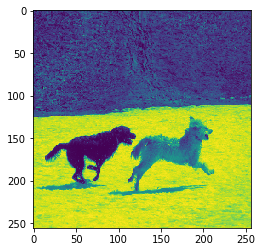

In [199]:
plt.imshow(arr[0,:,:,0])

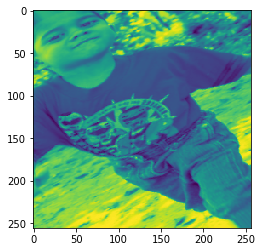

In [219]:
j=0
for i in datagen.flow(arr , batch_size=1):
    plt.imshow(i[0,:,:,0])
    break
    